In [184]:
%pip install scikit-learn pandas joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [185]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [186]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import necessary libraries

In [187]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

### Loading the data

In [188]:
df = pd.read_csv('../DataEngineering/reporting/merged.csv')

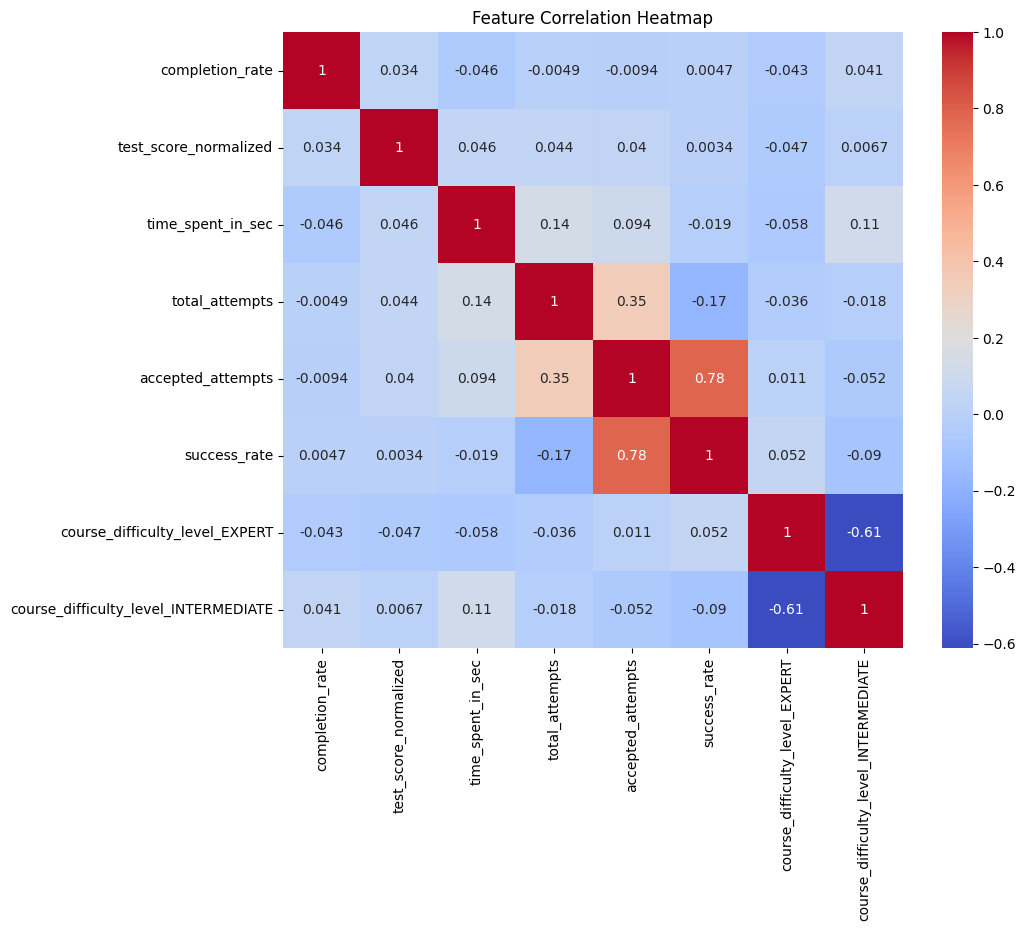

In [189]:
# Select the relevant columns
selected_columns = ['completion_rate', 'test_score_normalized', 'course_difficulty_level', 'time_spent_in_sec', 'total_attempts', 'accepted_attempts', 'success_rate']
# Filter the DataFrame to only include the selected columns
df_selected = df[selected_columns]

# Convert categorical columns to numeric (one-hot encoding)
df_selected_encoded = pd.get_dummies(df_selected, drop_first=True)

# Generate the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_selected_encoded.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()



In [190]:
# Select the relevant columns
selected_columns = ['completion_rate', 'test_score_normalized', 'course_difficulty_level', 
                    'time_spent_in_sec', 'total_attempts', 'accepted_attempts', 
                    'success_rate', 'learning_path_name']

# Filter the DataFrame to only include the selected columns
df_selected = df[selected_columns]

# Convert categorical columns to numeric (one-hot encoding)
df_selected_encoded = pd.get_dummies(df_selected, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = df_selected_encoded.corr()

# Get the columns that start with 'learning_path_name_' to isolate them
learning_path_columns = [col for col in correlation_matrix.columns if 'learning_path_name_' in col]

# Select the correlation values of numerical columns with learning path names
correlation_with_learning_path = correlation_matrix.loc[learning_path_columns, :]

# Display the correlation as a table
print("Correlation with Learning Path Name:")
print(correlation_with_learning_path)

Correlation with Learning Path Name:
                                             completion_rate  \
learning_path_name_Agile Methodologies              0.014842   
learning_path_name_Artificial Intelligence         -0.059726   
learning_path_name_Big Data                        -0.019794   
learning_path_name_Blockchain                      -0.008515   
learning_path_name_Cloud Computing                  0.042742   
learning_path_name_Cybersecurity                   -0.039403   
learning_path_name_Data Science                    -0.012772   
learning_path_name_DevOps                           0.012600   
learning_path_name_Frontend                         0.012873   
learning_path_name_Full Stack                       0.013432   
learning_path_name_Internet of Things (IoT)        -0.069637   
learning_path_name_Machine Learning                -0.059726   
learning_path_name_Mobile Development              -0.025888   
learning_path_name_Project Management              -0.014268   
lea

In [191]:
# Step 1: Group by 'emp_id' and 'learning_path_id' for aggregation
grouped_df = df.groupby(['emp_id', 'learning_path_id']).agg(
    avg_completion_rate=('completion_rate', 'mean'),
    avg_test_score_normalized=('test_score_normalized', 'mean'),
    avg_success_rate=('success_rate', 'mean'),
    total_time_spent=('time_spent_in_sec', 'mean')
).reset_index()

In [192]:
# Step 2: Calculate the combined score for each learning path
grouped_df['combined_score'] = (
    (grouped_df['avg_completion_rate'] * 0.2) +
    (grouped_df['avg_success_rate'] * 0.3) +
    (grouped_df['avg_test_score_normalized'] * 0.5)
)
# Drop intermediate columns now that we have combined_score
grouped_df.drop(columns=['avg_completion_rate', 'avg_success_rate', 'avg_test_score_normalized','total_time_spent'], inplace=True)


In [193]:
# Pivot the data to get combined_score and other metrics in columns by learning_path_id
df = grouped_df.pivot(index='emp_id', columns='learning_path_id', values=['combined_score'])

# Flatten the MultiIndex columns for easier access
df.columns = [f'{col[0]}_{col[1]}' for col in df.columns]
df.reset_index(inplace=True)

# Fill NaN values with 0 (if there are any missing values after the merge)
df.fillna(0, inplace=True)

# Load the best learning paths data and join on emp_id
best_learning_paths = pd.read_csv('../DataEngineering/reporting/best_learning_paths.csv')
df = df.merge(best_learning_paths, on='emp_id')
df.drop(columns=['completion_rate','time_spent_in_sec','success_rate','test_score_normalized','combined_score','learning_path_name'], inplace=True)

# Define the feature columns (exclude emp_id and target)
features = [col for col in df.columns if col not in ['emp_id', 'learning_path_id']]
# Use MinMaxScaler to scale features between 0 and 1
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

target = 'learning_path_id'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

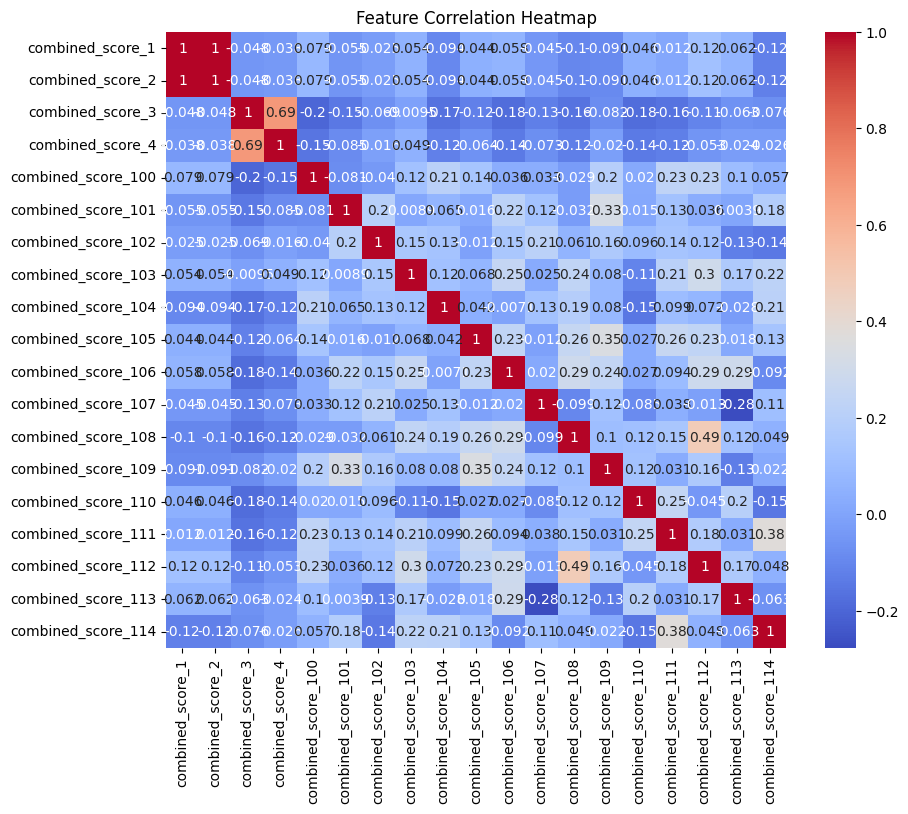

In [194]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

#### KNN Model

KNN Accuracy: 0.47619047619047616
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
         100       0.75      1.00      0.86         6
         101       0.50      1.00      0.67         1
         102       0.33      1.00      0.50         2
         103       0.00      0.00      0.00         3
         104       0.00      0.00      0.00         0
         105       1.00      0.33      0.50         3
         107       0.00      0.00      0.00         3
         109       0.00      0.00      0.00         1
         110       0.00      0.00      0.00         0
         113       0.00      0.00      0.00         1

    accuracy                           0.48        21
   macro avg       0.22      0.28      0.21        21
weighted avg       0.41      0.48      0.40        21

Model saved to knn_learning_path_model.pkl


c:\Users\HarshaVardhanAsadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HarshaVardhanAsadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HarshaVardhanAsadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

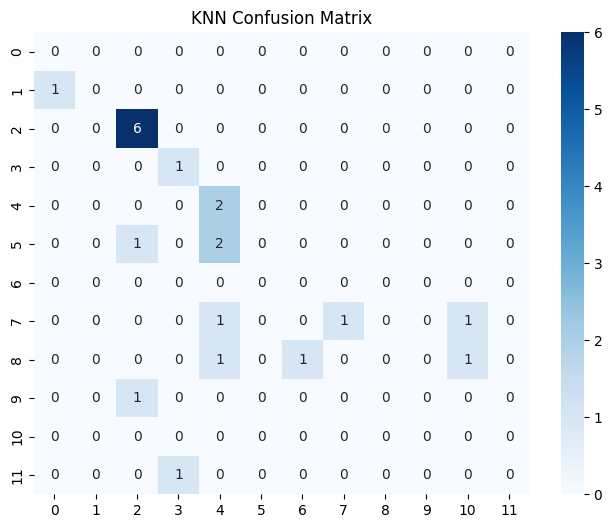

In [195]:
# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn.fit(X_train, y_train)

# Step 10: Evaluate KNN
y_pred_knn = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

# Add predictions to the dataframe
df['predicted_learning_path'] = knn.predict(df[features])

# Save the final dataframe with predictions
df.to_csv('knn_predicted_best_learning_paths.csv', index=False)

# Save the trained KNN model to a file
model_filename = 'knn_learning_path_model.pkl'
joblib.dump(knn, model_filename)

print(f"Model saved to {model_filename}")


# Confusion Matrix for KNN
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.show()

#### Random Forest Model

Random Forest Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
         100       0.67      0.33      0.44         6
         101       0.50      1.00      0.67         1
         102       0.33      1.00      0.50         2
         103       0.00      0.00      0.00         3
         104       0.00      0.00      0.00         0
         105       0.67      0.67      0.67         3
         107       0.00      0.00      0.00         3
         109       0.00      0.00      0.00         1
         110       0.00      0.00      0.00         0
         113       0.00      0.00      0.00         1

    accuracy                           0.33        21
   macro avg       0.18      0.25      0.19        21
weighted avg       0.34      0.33      0.30        21

Model saved to rf_learning_path_model.pkl


c:\Users\HarshaVardhanAsadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HarshaVardhanAsadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HarshaVardhanAsadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

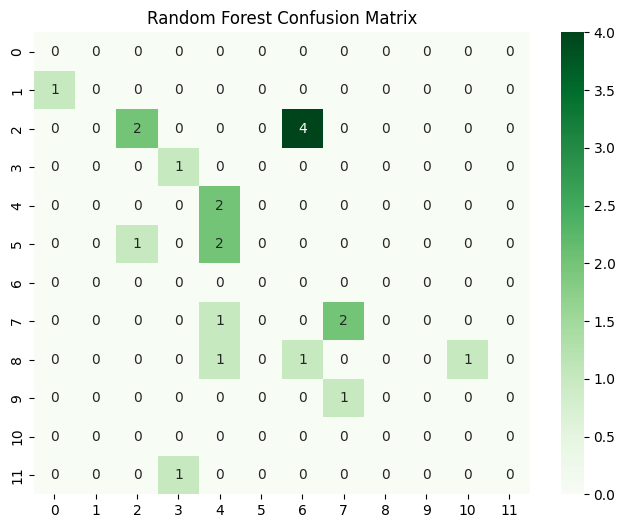

In [196]:
# Step 11: Train Random Forest Model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Step 12: Evaluate Random Forest
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Add predictions to the dataframe
df['predicted_learning_path'] = rf.predict(df[features])

# Save the final dataframe with predictions
df.to_csv('rf_predicted_best_learning_paths.csv', index=False)

# Save the trained Random Forest model to a file
model_filename = 'rf_learning_path_model.pkl'
joblib.dump(rf, model_filename)

print(f"Model saved to {model_filename}")


# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.show()

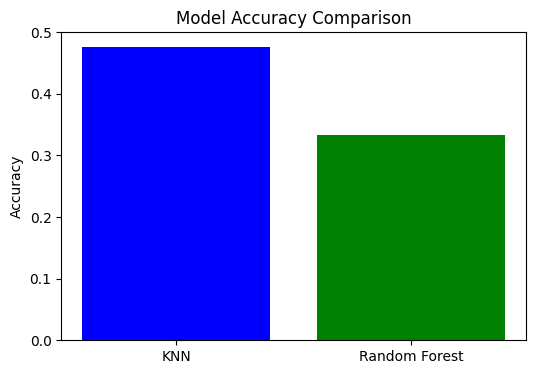

In [197]:
# Additional Step: Plot the accuracy of both models
accuracies = {
    'KNN': accuracy_score(y_test, y_pred_knn),
    'Random Forest': accuracy_score(y_test, y_pred_rf)
}

plt.figure(figsize=(6, 4))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()